## Tasks
- 다빈도 단어 바 그래프 (예쁘게) → 안지은
- 관련 주제별(대분류) 워드클라우드  → 안지은
- 관련 주제별 설명글 클러스터링 (K-means)
- 토픽 모델링 (Lda)
- 제로샷 모델

In [94]:
import pandas as pd
import numpy as np 
import re

# 시각화 라이브러리
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from collections import Counter
import  numpy as np
from PIL import Image
import plotly 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

font_path1 = r'C:/Windows/Fonts/NanumGothic.ttf' # 기본 matplotlib 폰트
font_path2 = r'C:/Windows/Fonts/bmdohyeon_ttf.ttf' # 배민 도현체 - 워드클라우드에 사용 
font = font_manager.FontProperties(fname = font_path1).get_name()
rc('font',family = font)

from konlpy import *
from konlpy.tag import *
kom = Komoran()


In [45]:
ori = pd.read_csv('preprocessed_data.csv')
ori.head()

,제목,발생기간,수집기간:시작일,수집기간:종료일,대주제,소주제,수집건수_웹사이트,수집건수_문서,수집건수_동영상,수집건수_이미지,내용,출처
0,2022년 20대 대통령선거(20대 대선),2022-03-09,2021-09-01,2022-02-26,사회과학,행정학,210,0,0,0,제20대 대통령선거가 2022년 3월 9일 실시된다. 제20대 대통령선거는 18세 ...,>\n중앙선거관리위원회\n(https://www.nec.go.kr/site/vt/e...
1,제16회 도쿄 패럴림픽,2021-08-24,2021-07-05,2021-11-07,예술,"오락,스포츠",261,0,0,0,2021년 8월 24일 9월 5일까지 일본 도쿄에서 열린 제16회 하계 패럴림픽으로...,>\n국제패럴림픽위원회(https://www.paralympic.org/)\n대한장...
2,2021년 대한민국 재보궐선거 (4·7 재보궐선거),2021-07-23,2021-07-05,2021-11-17,사회과학,행정학,271,0,0,0,"2020년 7월 10일 박원순 전 서울시장의 임기 중 사망, 오거돈 전 부산시장 자...",>\n중앙선거관리위원회\n(https://www.nec.go.kr/site/nec/...
3,제32회 2020 도쿄올림픽,2021-07-23,2020-11-03,2021-11-17,예술,"오락,스포츠",511,0,0,0,2021년 7월 23일부터 8월 8일까지 일본 도쿄에서 열린 제32회 하계올림픽으로...,>\n도쿄올림픽 공식홈페이지(https://olympics.com/ko/olympi...
4,문화콘텐츠,2021-01-01,2022-01-27,2022-12-31,예술,"공연예술,매체예술",603,0,0,0,“한류가 아시아와 그 너머 다른 국가들에서도 한국의 문화적 영향력을 확산시켜 한국을...,>\n한국콘텐츠진흥원(https://www.kocca.kr/cop/bbs/view/...


# 0. 명사 분석을 위한 단어 전처리

In [48]:
#  불용어 파일 로드
# 출처 : https://junior-developer.tistory.com/8  + 기타 추가 단어

f = open("koreanStopwords.txt", 'r', encoding = 'utf-8')
lines = f.readlines()
stopwords = []
for line in lines:
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()

# 데이터 프레임 내 모든 레코드의 '내용' 을 합친 후, 명사 추출된 단어 개수 카운트하여 딕셔너리로 리턴해주는 함수
def concat_all_sent(df):
    words = []
    cnt_dict = {}
    for word in df['내용'] : 
        words.append(word)   
    sentence = ' '.join(words)
    new_str = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sentence)
    nouns = kom.nouns(new_str)
    cnt_dict = Counter(nouns)
    return cnt_dict

# 딕셔너리를 데이터 프레임 형태로 바꿔주는 함수
def dict_to_df(dict):
    dict_to_df = pd.DataFrame(columns = ['형태소', '빈도'])
    dict_to_df['형태소'] = dict.keys()
    dict_to_df['빈도'] = dict.values()
    dict_to_df = dict_to_df.sort_values('빈도',ascending = False)
    return dict_to_df

# 데이터 프레임의 데이터를 딕셔너리 형태로 바꿔주는 함수
def df_to_dict(df):
    new_dict = {}
    for i in range(len(df)):
        new_dict[df['형태소'][i]] = df['빈도'][i]
    return new_dict

# 단어별 빈도수 딕셔너리에서 불용어 제거하는 함수
def filter_word(dict):
    df = dict_to_df(dict)
    new_dict = {}
    for i in range(len(df)):
        if (len(df['형태소'][i]) > 1 and df['형태소'][i] not in stopwords) :
            new_dict[df['형태소'][i]] = df['빈도'][i]
    new_df = dict_to_df(new_dict)
    new_df.reset_index(inplace = True , drop = True)
    return new_df

# 최종 : 데이터프레임 넣으면 해당 부분에 대해 불용어 제거하여 명사 카운트해주는 함수
def filtering(df):
    tg_dict = concat_all_sent(df)
    final_df = filter_word(tg_dict)
    return final_df

# 1. 시각화

In [98]:
# 빈도수 30개 그래프 시각화
def vis_cnt(df, title):
    data1 = go.Bar(x=df['형태소'], y=df['빈도'], name ='빈도수')
    data2 = go.Line(x=df['형태소'], y=df['빈도'], name = '추세선')
    layout = go.Layout(title=title)
    fig = go.Figure(data=[data1, data2], layout=layout)
    fig.show()

# 워드클라우드 시각화
def make_wc(dict, title, c_map):
    fig = plt.figure(figsize = (10, 10))
    wordcloud = WordCloud(
    font_path = font_path2, 
    background_color='white',  
    colormap=c_map
    ).generate_from_frequencies(dict)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.box(False)
    plt.axis(False)
    plt.show()

## 1-0. 전체 단어 집합 

In [79]:
all_cont = filtering(ori)
all_cont_dict= df_to_dict(all_cont[:300])

### 1-0-1. 상위 30개 단어 빈도수

In [99]:
vis_cnt(all_cont[:30], 'oasis 개별 컬렉션 설명글 단어 집합 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### 1-0-2. 상위 300 개 단어 워드클라우드 

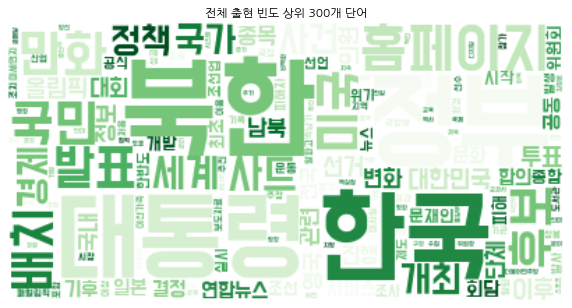

In [96]:
make_wc(all_cont_dict, '전체 출현 빈도 상위 300개 단어', 'Greens')

# 2. 머신러닝

## 2-1. 토픽모델링

### 2-2-1. K-means 클러스터링

### 2-2-2. 잠재 디리클레 할당(LDA)

### 2-2-3